# Ship Damage Probability
Should I roll the dice? This notebook provides the probabilities that will help Seafall players make that decision.

In [1]:
%matplotlib inline

import itertools
import matplotlib
import matplotlib.pyplot
import numpy
import os
import pandas
import scipy.misc
import scipy.special
import seaborn

In [2]:
# colormap for data visualizations
cmap = seaborn.cubehelix_palette(n_colors = 20, start = 0.8, rot = 0.75,
                                gamma = 0.3, hue = 2.0, dark = 0.005,
                                light = 0.95, reverse = True, as_cmap = True)

## A cursed throw during the prologue
I went to explore a region on the first island, my flag ship being supported by the second ship in my fleet. With the Woodsman as my advisor I would have 4 dice to roll where I needed three successes to avoid damage to my ship. I cast my dice and recoiled once they settled on 3 blanks and merely 1 success. I felt this had to have been some rather unlucky outcome (though my endeavor was ultimately successful). Was I cursed?

## Counting the outcomes of dice rolls
Dice rolls can be [framed](http://math.stackexchange.com/questions/900672/how-many-combinations-from-rolling-5-identical-dice) as [stars and bars](http://math.stackexchange.com/questions/208377/combination-with-repetitions) problems. This is a clever way to frame the combinatorics of dice rolling. The combination formula is used to choose the location of the bars, whose position determines how many dice show a particular face. The stars between the bars represent the number of dice showing a particular face; the identity of that face is determined by how many bars are to the right (or left) of the star(s). If two bars are adjacent that means there aren't any dice showing the particular face defined by the position between those bars.

\begin{equation}\text{unique dice combinations} = \binom{n - 1 + k}{n - 1}\end{equation}

\begin{equation}n = \text{the number of faces on a die}\end{equation}

\begin{equation}k = \text{the size of the dice pool}\end{equation}

*Note that all dice in the pool must be identical. In fact, unless otherwise stated, it is assumed that the dice pool consists of identical dice.*

### The combination formula is essential
The combination formula will again prove useful for counting outcomes when considering only two possibilities. In Seafall, often it only matters whether the face of a die is blank or not. In these cases, the combination formula can be used to count the outcomes by enumerating the ways a pool of dice can be divided into two sets. In other words, from the dice pool choose a given number of dice to be part of the *blank* set; since there are only two sets this action leaves only one possibility for the dice in the complementary *success* set.

\begin{equation}\text{unique dice combinations} = \binom{n}{k}\end{equation}

\begin{equation}n = \text{the size of the dice pool}\end{equation}

\begin{equation}k = \text{the number of blanks}\end{equation}

Looking ahead, when there are more than two outcomes we'll need the multinomial coefficient formula, which reduces to the combination formula when rolling dice is equivalent to a weighted coin flip. The multinomial formula comes into play during more complex situations encountered in Seafall. For the most common encounters on the high seas we'll be using [combinations](https://en.wikipedia.org/wiki/Combination) to do the heavy lifting of the calculations.

In [3]:
# FWIW, total number of unique outcomes from rolling 4, 6-sided dice.
# Note that stars-and-bars is also called combination with repition.
print("stars and bars", scipy.misc.comb(6, 4, repetition=True)) # scipy.misc.comb(# of faces, # of dice, repitition=True)
# permutation
print("permutation", scipy.special.perm(6,4))
# combination: asks, "Given 4 dice, how many combinations can be made by choosing 2 of the 4."
print("combination", scipy.misc.comb(6,4))

stars and bars 126.0
permutation 360.0
combination 15.0


Since the possibilities of rolling a blank is weighted, i.e. the chance of rolling a blank does not equal the probability of *not* rolling a blank, counting the outcomes alone will not yield the correct probability. Each outcome for a given combination will however share the same probability, so it is only a matter of finding the probability for a single outcome and multiplying it by the total number of unique outcomes.

In [4]:
cursed_probability = (1.0/3)**3 * (2.0/3) * scipy.misc.comb(4,1) + (1.0/3)**4
print(cursed_probability)

0.111111111111


My roll (or worse) would only happen 11% of the time, so I would consider myself unlucky and stop short of calling myself cursed.

# A simulation
Before we explicitly calculate the probabilites for potential ship damage, simulating the dice rolls to sample the actual probability space is a useful sanity check we can refer to as we code-up the exact probabilities.

We will map a random number from a uniform distribution $\left[0, 1\right]$ to a piecewise function that reflects the probability of a given face resulting from a roll. When we only care about blanks and successes the 6 sides of the dice can be treated as a weighted coin instead. On one "side" of the coin is the blank result shown by 2 of the 6 faces, so it has a $1/3$ chance of happening. That's all we need to know, because any other result will be considered a success. The piecewise function will return a 1 if the random variable is  $<= 1/3$, and a 0 otherwise. The end result will be the total number of blanks found after rolling a dice pool.

In [5]:
p_blank = 1.0/3

def simulate_roll(total_dice):
    x = numpy.random.uniform(size=total_dice)
    conds = [x <= p_blank, (x > p_blank)]
    # each blank counts as 0, other successes count as 1
    roll_array = numpy.piecewise(x, conds, [0, 1])
    return numpy.sum(roll_array)

def success_roll_simulator(total_dice, n):
    sim_list = [simulate_roll(total_dice) for i in range(n)]
    return numpy.array(sim_list)
    #return {"num_success" : num_success_array, "p_success" : p_success_array}
    
n = 10000
success_count_list = [success_roll_simulator(i, n) for i in numpy.arange(1,16)]
for i, array in enumerate(success_count_list):
    array[array < 0] = 0
    success_count_list[i] = array
success_count_itemfreq = [scipy.stats.itemfreq(a) for a in success_count_list]

sdp_sim = numpy.zeros((15,16))
for i, array in enumerate(success_count_itemfreq):
    for j in array:
        sdp_sim[i, j[0].astype(int)] = j[1]/n
        
# for the greater than or equal probabilites, sum along the rows
sdp_sim_gte = numpy.zeros((15,15))

for (i, j), _ in numpy.ndenumerate(sdp_sim_gte):
    sdp_sim_gte[i, j] = numpy.sum(sdp_sim[i, j+1:])

row_blank = numpy.arange(1,16) # number of dice showing the blank face
col_dice = numpy.arange(1,16) # number of dice in the pool
sdp_sim_gte_dataframe = pandas.DataFrame(data = sdp_sim_gte, index = row_blank, columns = col_dice)
sdp_sim_gte_dataframe_stack = sdp_sim_gte_dataframe.stack().reset_index().rename(
    columns = {
        "level_0" : "number_success", 
        "level_1" : "number_dice_pool", 
        0 : "probability_GTE_to_number_success"})

sdp_sim_gte_pivot = sdp_sim_gte_dataframe_stack.pivot("number_success", 
                                                      "number_dice_pool", 
                                                      "probability_GTE_to_number_success")

sdp_sim_gte_mask = numpy.logical_or(sdp_sim_gte_pivot > 0.999, numpy.triu(numpy.ones((15,15)), 1))

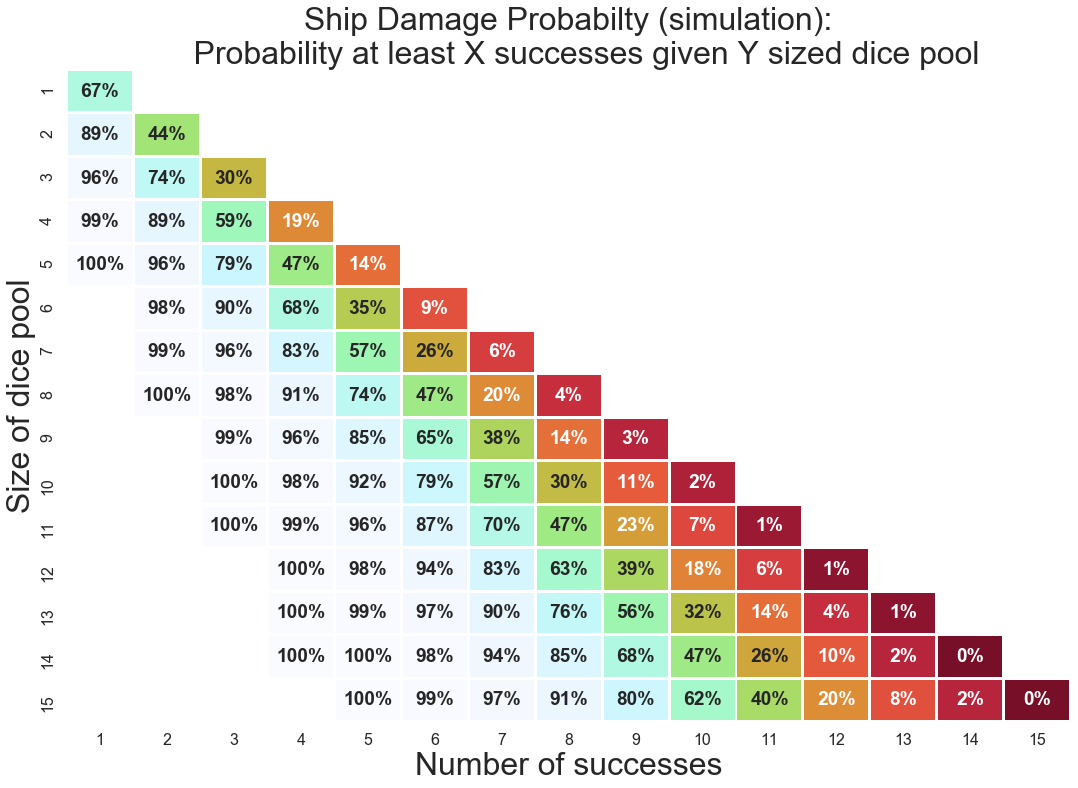

In [6]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(18, 12))
ax = seaborn.heatmap(sdp_sim_gte_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_sim_gte_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty (simulation):
    Probability at least X successes given Y sized dice pool""", 
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig(os.path.join("charts", "ship_damage_probabilities_1to15_simulation.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15_simulation.svg"), format="svg", dpi=1200)

In [7]:
p_blank = 1.0/3

def prob_success(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        p = (p_blank)**(total_dice-num_success) * \
        (1.0-p_blank)**num_success * \
        scipy.misc.comb(total_dice, num_success)
    return p

In [8]:
cursed_probability = prob_success(0,4) + prob_success(1,4)
print(cursed_probability)

0.111111111111


In [9]:
def prob_success_or_better(num_success, total_dice):
    if total_dice < num_success:
        p = 0.0
    else:
        rng_blank = numpy.arange(num_success, total_dice + 1)
        array_blank = [prob_success(n, total_dice) for n in rng_blank]
        p = numpy.sum(array_blank)
    return p

In [10]:
cursed_probability = 1 - prob_success_or_better(2,4)
print(cursed_probability)

0.111111111111


# Ship Damage Probability (SDP) matrix
There are 15 dice within Seafall, so a matrix should be large enough to assess the situation where all 15 are rolled. The early game does not use near this many dice, but eventually there is a island to discover at sea with a 30 defense! To cover all these situations several visualizations will be created.

In [11]:
row_success = numpy.arange(1,31) # number of dice showing the blank face
col_dice = numpy.arange(1,31) # number of dice in the pool
sdp = numpy.zeros((numpy.size(row_success),numpy.size(col_dice)))
prob = [prob_success_or_better(*i) for i in itertools.product(row_success, col_dice)]
ind = [tuple(numpy.subtract(i,1)) for i in itertools.product(row_success, col_dice)]
for idx, val in enumerate(ind):
    sdp[val] = prob[idx]

In [12]:
# http://stackoverflow.com/questions/41474284/how-to-convert-a-matrix-into-column-array-with-pandas-python
sdp_dataframe = pandas.DataFrame(data = sdp, index = row_success, columns = col_dice)
sdp_dataframe_stack = sdp_dataframe.stack().reset_index().rename(
    columns = {
    "level_0" : "number_successes", 
    "level_1" : "number_dice_pool", 
    0 : "probability_GTE_to_number_successes"}
)

sdp_dataframe_15 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_successes"] < 16) &
                                          (sdp_dataframe_stack["number_dice_pool"] < 16)]

sdp_pivot = sdp_dataframe_15.pivot("number_dice_pool", 
                                      "number_successes", 
                                      "probability_GTE_to_number_successes")
sdp_mask = numpy.logical_or(sdp_pivot > 0.999, numpy.triu(numpy.ones((15,15)), 1))

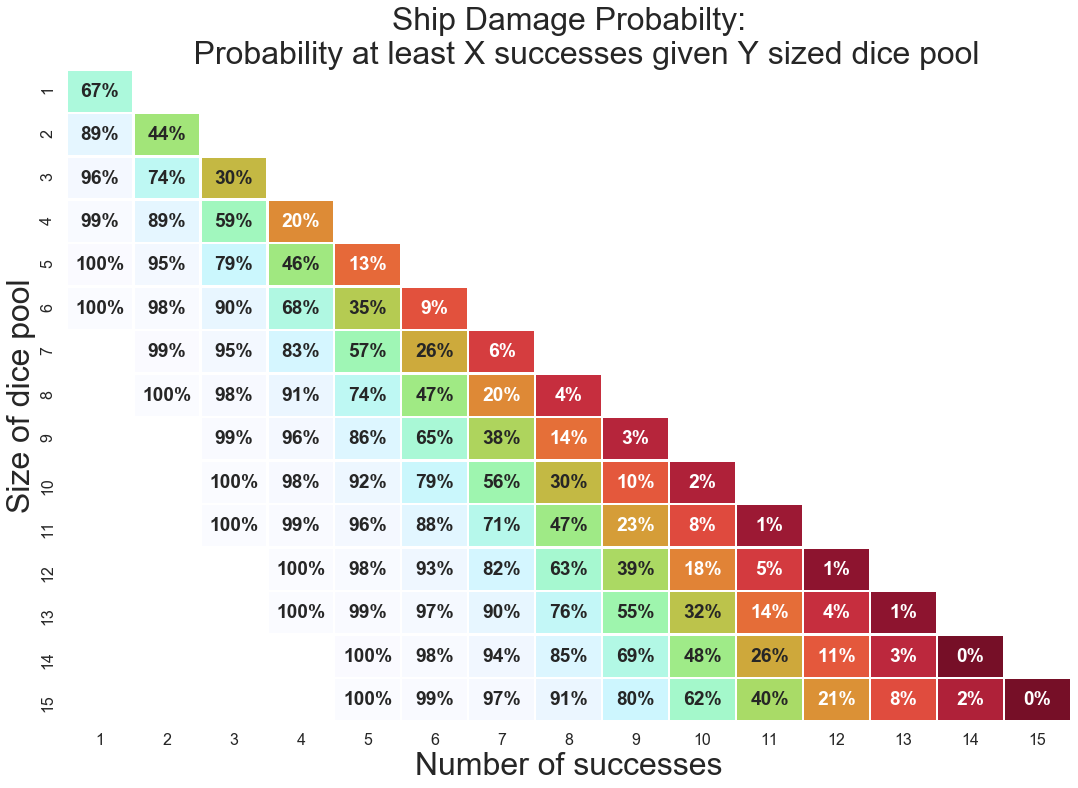

In [13]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(18, 12))
ax = seaborn.heatmap(sdp_pivot, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 1.5, vmin=0.0, 
                     vmax=1.0)
ax.set_title(
    """Ship Damage Probabilty:
    Probability at least X successes given Y sized dice pool""",
    fontsize=32)
ax.set_xlabel("Number of successes", fontsize=32)
ax.set_ylabel("Size of dice pool", fontsize=32)
fig = ax.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to15.svg"), format="svg", dpi=1200)

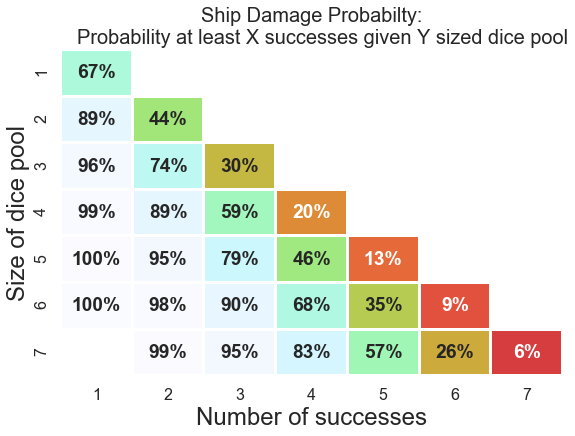

In [14]:
seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(9, 6))
sdp_dataframe_7 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_successes"] < 8) &
                                          (sdp_dataframe_stack["number_dice_pool"] < 8)]

sdp_pivot_7 = sdp_dataframe_7.pivot("number_dice_pool", 
                                    "number_successes", 
                                    "probability_GTE_to_number_successes")

sdp_mask_7 = numpy.logical_or(sdp_pivot_7 > 0.999, numpy.triu(numpy.ones((7,7)), 1))

ax2 = seaborn.heatmap(sdp_pivot_7, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask_7, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 2.0, vmin=0.0, 
                     vmax=1.0)
ax2.set_title(
    """Ship Damage Probabilty:
    Probability at least X successes given Y sized dice pool""",
    fontsize=20)
ax2.set_xlabel("Number of successes", fontsize=24)
ax2.set_ylabel("Size of dice pool", fontsize=24)
fig = ax2.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to7.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_1to7.svg"), format="svg", dpi=1200)

# A daring raid upon my province
The end of the 2nd game was nigh. I had 10 glory and was primed to secure a 2 glory treasure and victory on my next turn. I had the most glory after my last turn, but it was a close game. Mike and Joe both had 9 glory. I had accumulated two treasures to this point and Mike eyed my overflowing vault enviously; I had a target on my back. Unfortunately, my ships were both at sea, so my home port was undefended. Mike took advantage and attacked! He had 6 dice to roll and needed 5 successes to raid my treasure room. I had knew Mike was tempted, but held out hope Mike wouldn't attack at all. Alas, Mike could not resist! Here is how the numbers break down:

Look at row 6 and column 2. There was a 64.9% chance that Mike would have rolled 2 or more blanks. In otherwords, Mike had a 35.1% chance of 5 or more successes that he needed to plunder my treasure! I hope my luck changes soon.

Eventually, dice pools will exceed the number of dice provided, 15, in the game of SeaFall.

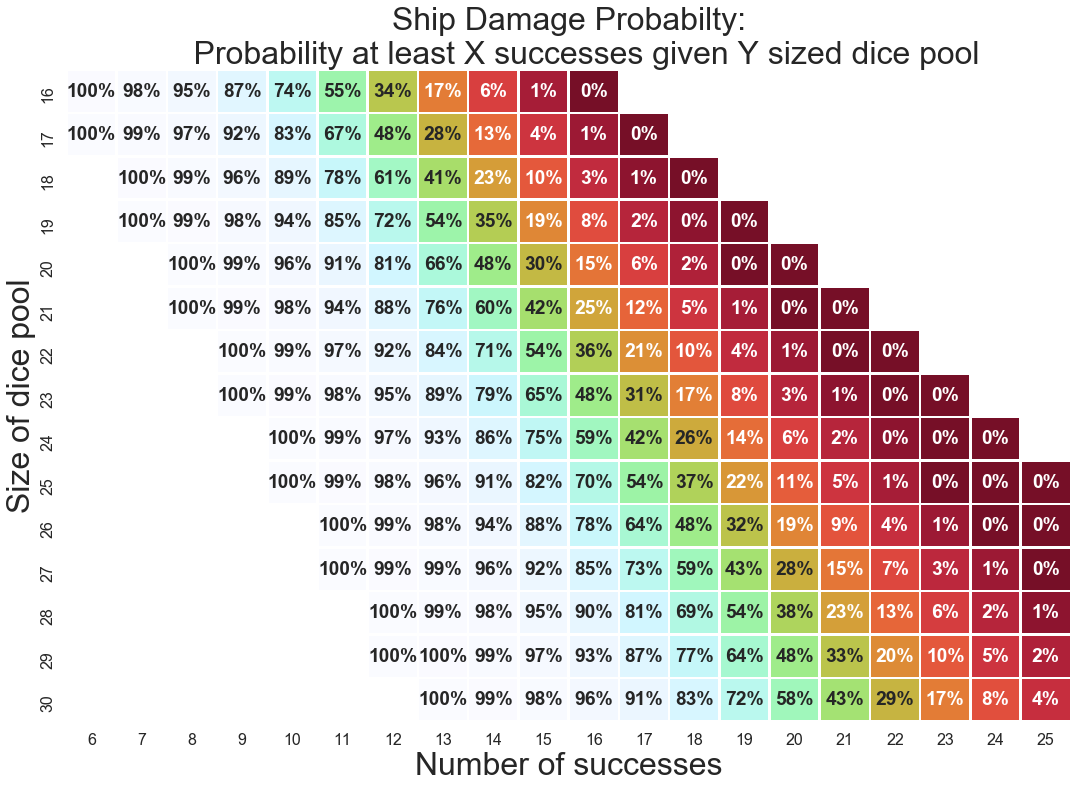

In [15]:
sdp_dataframe_30 = sdp_dataframe_stack.loc[(sdp_dataframe_stack["number_successes"] > 5) &
                                           (sdp_dataframe_stack["number_successes"] < 26) &
                                          (sdp_dataframe_stack["number_dice_pool"] > 15)]

sdp_pivot_30 = sdp_dataframe_30.pivot("number_dice_pool", 
                                    "number_successes", 
                                    "probability_GTE_to_number_successes")

sdp_mask_30 = numpy.logical_or(sdp_pivot_30 > 0.999, numpy.triu(numpy.ones((15,20)), 11))

seaborn.set(style = "white")
seaborn.set_context("poster")
matplotlib.pyplot.figure(figsize=(18, 12))
ax2 = seaborn.heatmap(sdp_pivot_30, annot = True, cmap = cmap,
                     cbar = False, mask = sdp_mask_30, annot_kws = {"weight" : "extra bold"},
                     fmt = ".0%", linewidths = 1.5, vmin=0.0, 
                     vmax=1.0)
ax2.set_title(
    """Ship Damage Probabilty:
    Probability at least X successes given Y sized dice pool""",
    fontsize=32)
ax2.set_xlabel("Number of successes", fontsize=32)
ax2.set_ylabel("Size of dice pool", fontsize=32)
fig = ax2.get_figure()
fig.savefig(os.path.join("charts","ship_damage_probabilities_16to30.pdf"))
fig.savefig(os.path.join("charts","ship_damage_probabilities_16to30.svg"), format="svg", dpi=1200)